# Georectify Image

In [1]:
import numpy as np
import numpy.matlib
import scipy.io
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy import interpolate

#Load data from MATLAB
mat = scipy.io.loadmat('Georectify_Python.mat')

I = mat['I']
nGcps = mat['nGcps'][0,0]

### 1. Get data about the selected image and the site from previous stages.
### 2. Check if the image has already been rectified.
### 3. Retrieve the GCP (ground control point) real world location information from the database.
### 4. Define the initial external camera parameters.
### 5. Prompt the user to interactively select the location of each GCP within the image:

After running the next code cell, and the figure appears, follow the steps below to select the GCP locations:

1. Click and hold the left mouse button while dragging inside the image to create a rectangle to zoom in on.
2. Release the left mouse button and the zoom will occur.
3. Repeat the above steps until you have zoomed in enough on the location of interest.
4. Press any key.
5. When the cursor is moved it becomes a selector to locate the exact location of the GCP.
6. Click on the GCP location.
7. Click the 'reset original view' button (i.e. the house) on the left of the tool bar. You should now see a green dot in the GCP location specified.
***
8. Repeat steps 1 to 7 for each GCP.

#### **Note:** This user interface is only for demonstration. The variable UV generated will be replaced by a predefined data set for the later steps in this notebook.

In [2]:
%matplotlib qt
fig, axes = plt.subplots()
axes.imshow(I)
UV = np.zeros((nGcps,2))
for i in np.linspace(1, nGcps, nGcps, dtype=int, endpoint=True):
    fig.canvas.toolbar.zoom()
    while not plt.waitforbuttonpress(): pass
    fig.canvas.toolbar.zoom()
    A = plt.ginput(n=1, timeout=0)
    axes.plot(A[0][0], A[0][1],'go', markersize = 3)
    UV[(i-1),:] = A[0]
plt.close()

The UV values have now been determined and are defined in the variable **UV**:

In [3]:
UV

array([[ 347.84017595, 1330.08064516],
       [ 606.45768747, 1152.95286971],
       [1042.85570923,  323.34820374],
       [1156.37232248,  268.19556418],
       [1350.16554225,  281.74928318],
       [  75.17144544,  598.21411705],
       [ 221.85385394,  469.26151122]])

### 6. Establish the unknown camera parameters

Generate a set of potential focal lengths, **fx** for testing

In [2]:
HFOV_min = mat['HFOV_min']
HFOV_max = mat['HFOV_max']
Nu = mat['Nu']

A = np.arange(5, 500005, 5)
B = np.arange(5, 500005, 5)

fx_max = 0.5*Nu/np.tan(HFOV_min*np.pi/360) #From Eq. 4 in Harley et al. (2019)
fx_min = 0.5*Nu/np.tan(HFOV_max*np.pi/360) #From Eq. 4 in Harley et al. (2019)
fx_min = interpolate.interp1d(A, B, kind='nearest')(fx_min)
fx_max = interpolate.interp1d(A, B, kind='nearest')(fx_max)

In [3]:
print(fx_min)
print(fx_max)

[[1460.]]
[[2815.]]


In [4]:
fx = np.arange(fx_min, fx_max+5, 5)

Load data generated in MATLAB to use in the following steps:

In [5]:
GlobsOutput = scipy.io.loadmat('GlobsOutput.mat')

xyz = GlobsOutput['xyz'].astype(float)
UV = GlobsOutput['UV'].astype(float)
beta0 = GlobsOutput['beta0']

Define the Function which applies the pinhole camera model:

In [6]:
def TESTFITFUNC(xyz, beta0, beta1, beta2, beta3, beta4, beta5):
    #note: scipy.optimize.curve_fit required the parameters to fit as separate arguments in
    #the function definition. This is why beta1, beta2 etc... are written rather than just beta.
    mat = scipy.io.loadmat('RectifyImagePython.mat')
    
    fx = mat['fx'][0,0].astype(float)
    #note: it was found that -fy when data type is unit 16 returned a very unusul result.
    #so it is impotant these are dtype: float.
    fy = mat['fy'][0,0].astype(float)
    c0U = mat['c0U'][0,0].astype(float)
    c0V = mat['c0V'][0,0].astype(float)

    K = np.array([[fx, 0, c0U],[0, -fy, c0V],[0, 0, 1]]).astype(float)

    R = np.zeros((3, 3))

    def angles2R(a, t, s):
        R[0,0] = np.cos(a) * np.cos(s) + np.sin(a) * np.cos(t) * np.sin(s)
        R[0,1] = -np.cos(s) * np.sin(a) + np.sin(s) * np.cos(t) * np.cos(a)
        R[0,2] = np.sin(s) * np.sin(t)
        R[1,0] = -np.sin(s) * np.cos(a) + np.cos(s) * np.cos(t) * np.sin(a)
        R[1,1] = np.sin(s) * np.sin(a) + np.cos(s) * np.cos(t) * np.cos(a)
        R[1,2] = np.cos(s) * np.sin(t)
        R[2,0] = np.sin(t) * np.sin(a)
        R[2,1] = np.sin(t) * np.cos(a)
        R[2,2] = -np.cos(t)
    
    angles2R(beta3, beta4, beta5)

    I = np.eye(3)
    C = np.array([beta0, beta1, beta2]).astype(float)
    #to use np.hstack in the next cell, the arrays I and C both need to be 2D:
    C.shape = (3,1)

    IC = np.hstack((I,-C))

    P = np.matmul(np.matmul(K,R),IC)
    #note when comparing the output to P in MATLAB, the 1st and 3rd entries in the bottom
    #row are too small to show up in the MATLAB way of displaying the data. The results are
    #the same

    P = P/P[2,3]

    #note: instead of np.tranpose, an alternative is to place ".T" after the object to be transposed.
    #I keep np.transpose since this makes is more obvious to someone analysing the code.
    UV = np.matmul(P,np.vstack((np.transpose(xyz), np.ones((1, len(xyz)), dtype = float))))

    UV = UV/np.matlib.repmat(UV[2,:],3,1)
    UV = np.transpose(np.concatenate((UV[0,:], UV[1,:])))
    return UV

Perform a non-linear regression fit of the function ***TESTFITFUNC*** to the provided (U,V) and (x,y,z) data. to generate the estimations of the unknown parameters (in **beta_opt**).

In [7]:
beta_opt, Cov = curve_fit(TESTFITFUNC, xyz, np.concatenate((UV[:,0], UV[:,1])),beta0)
beta_opt

array([-1.71807884e-01,  1.55786045e-01,  1.71404018e+01, -4.05849281e-01,
        1.30282771e+00, -5.59067456e-03])

In [8]:
beta = beta_opt

**Steps required to calculate mean squared error of the non-linear regression fit in Python:**

Apply the pinhole camera model in reverse to find the (U,V) coordinates generated from the known world coordinates (x,y,z) using the fitted parameters.

In [9]:
UV_pred = TESTFITFUNC(xyz, beta[0], beta[1], beta[2], beta[3], beta[4], beta[5])

Compare these to the original UV coordinates provided by user input:

In [10]:
UV = GlobsOutput['UV'].astype(float)
UV = np.concatenate((UV[:,0], UV[:,1]))
UV_true = UV

apply the function **mean_squared_error**:

In [11]:
from sklearn.metrics import mean_squared_error

mean_squared_error(UV_true, UV_pred)*((2*nGcps)/((2*nGcps)-beta0.shape[1]))

10.010494510522651

### 7. Plot the GCP locations generated by the resolved camera parameters onto the image.

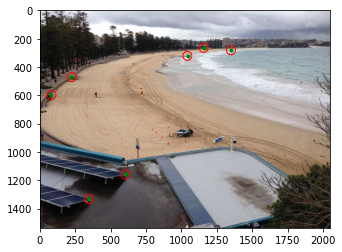

In [12]:
mat = scipy.io.loadmat('UV_computed.mat')
UV = mat['UV']
UV_computed = mat['UV_computed'].reshape((-1,2))

fig2, axes = plt.subplots()
axes.imshow(I)
axes.plot(UV[:,0], UV[:,1],'go', markersize = 3)
axes.scatter(UV_computed[:,0], UV_computed[:,1], s=80, facecolors='none', edgecolors='r')

### 8. Create the plan image

Load data from MATLAB:

In [13]:
mat = scipy.io.loadmat('build___rect___products___Python.mat')

images_xy = mat['images_xy']
images_z = mat['images_z']
I = mat['I'].astype(float)
beta = mat['beta']
dn = mat['dn']

Generate a grid for the world space to be covered in the plan image:

In [14]:
[NV, NU, NC] = I.shape
#Detail the minimum and maximum x and y coordinates and the spacing in x and y of the real-world grid
xy = images_xy
z = images_z[0,0]

In [15]:
#Create the x array to be passed to the meshgrid function
x = np.arange(xy[0,0], (xy[0,2] + xy[0,1]), xy[0,1])
#Creates the y array to be passed to the meshgrid function
y = np.arange(xy[0,3], (xy[0,5] + xy[0,4]), xy[0,4])

In [16]:
#Meshgrid generated
X, Y = np.meshgrid(x, y)

In [17]:
images_dn = dn
#Zeros array with same dimensions as the grid and depth of 3 for each of RGB values
images_sumI = np.zeros((len(y),len(x),3))
#Zeros array with 2D grid dimensions
images_N = np.zeros(X.shape)

In [18]:
#Create an array representing the (x,y,z) coordinates of every point in the grid. shape: (nPoints, 3)
xyz = np.column_stack((X.T.flatten(), Y.T.flatten(), np.matlib.repmat(z, len(X.T.flatten()), 1)))

Determine the (U,V) coordinates corresponding to all points in the grid: 

In [19]:
#All xyz coordinates in the grid are given their corresponding UV coordinates which are rounded to nearest integer
UV = np.around(TESTFITFUNC(xyz, beta[0,0], beta[0,1], beta[0,2], beta[0,3], beta[0,4], beta[0,5]))
#Order='F' means the reshape is done column by column.
UV = np.reshape(UV, (-1, 2), order='F')

Determine which of the grid points can extract data from the oblique image:

In [20]:
def onScreen(U, V, Umax, Vmax):
    Umin = 1
    Vmin = 1

    #Column of zeros, same length as UV(from the grid) (ie one for each coord set)
    yesNo = np.zeros((len(U),1))
    #Gives at 1 for all the UV coords which have existing corresponding pixel values from the oblique image
    on = np.where((U>=Umin) & (U<=Umax) & (V>=Vmin) & (V<=Vmax)) [0]
    yesNo[on] = 1
    return yesNo

In [21]:
#Gives the index of all the UV coords which will have pixel data
good = np.where(onScreen(UV[:,0], UV[:,1], NU, NV) == 1)[0]

In [22]:
UV = UV.astype(int)
#arr is an array containing the useful UV coordinates with the V coords on top of the U coords
arr = np.array([UV[good,1], UV[good,0]])
#returns the linear indices of the usful coordinates
ind = np.ravel_multi_index(arr, (NV, NU), mode='clip', order='F')

Transfer the data from the oblique image pixels to the corresponding points in the grid:

In [23]:
#same as before size of grid with 3 depth for RGB
foo = images_sumI

In [24]:
for i in [0, 1, 2]:
    #Take each of the RGB information arrays
    I3 = I[:,:,i]
    #Reshape it so that it is one column (column by column)
    I3 = np.reshape(I3, (-1, 1), order='F')
    #Extract the data from the image pixels corresponding to xyz grid points
    I2 = I3[ind]
    #Make bar the same shape as the real-world grid
    bar = foo[:,:,i]
    #Straignten it out
    bar = np.reshape(bar, (-1, 1), order='F')
    #The relevant coordinates of bar (real-world grid) will now attain the pixel data
    bar[good] = I2
    #Reshape bar
    bar = np.reshape(bar, (len(images_sumI), -1), order='F')
    #Put the data back into foo to hold it safely
    foo[:,:,i] = bar

Allocate the data generated to variables for plotting:

In [25]:
images_dn = dn
#x grid axis
images_x = x
#y grid axis
images_y = y
#Pixel info in the grid
images_sumI  = foo
#xyz coords of each grid point
images_xyz = xyz
images_N = np.reshape(images_N, (-1, 1), order='F')
#Puts a 1 in every location where there is pixel data in the grid
images_N[good] = 1
images_N = np.reshape(images_N, (X.shape[0], X.shape[1], 1), order='F')

In [26]:
#Copies N to fit the shape of the RGB grid
N = np.tile(images_N, (1, 1, 3))

Plot the georectified image:

<ipython-input-27-095ab583d005>:2: RuntimeWarning: invalid value encountered in true_divide
  finalImages_timex = (images_sumI/N).astype(int)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Georectified image - Python')

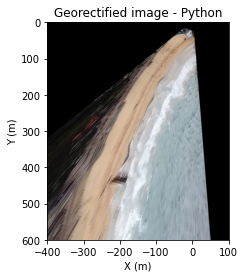

In [27]:
#All grid coordinates without pixel data are assigned a NaN value due to the division by 0 from N:
finalImages_timex = (images_sumI/N).astype(int)
plt.imshow(finalImages_timex, extent = (xy[0,0], xy[0,2], xy[0,5], xy[0,3]))
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Georectified image - Python")